In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
import ot  
from scipy.spatial import procrustes


In [2]:
def generate_point_cloud(kind='gaussian', n=1000, noise=0.05, random_state=42)
"""
Generate two-dimensional point clouds of different distributions:
-kind = 'gaussian' : Standard normal distribution (N(0,I ₂))
-kind = 'spiral' : Two-dimensional spiral with a small amount of noise added
-kind = 'circle' : Unit circumference, with a small amount of noise added
-kind = 'banana' : Two-dimensional banana-shaped curve (y = x^2) + noise
-kind = 'swissroll': Swiss roll (Only two dimensions are taken and standardized after generation)
Parameter:
kind: String, point cloud type
n: Number of points
noise: Amplitude of noise
random_state: Random seed
Return:
X: A numpy array of (n,2)
"""

    np.random.seed(random_state)
    if kind == 'gaussian':
        # 1. First, it becomes a "clean" standard normal point cloud X0
        X0 = np.random.randn(n, 2)
        # 2. add gaussian noise
        noise_mat = noise * np.random.randn(n, 2)
        X = X0 + noise_mat

    elif kind == 'spiral':
        t = np.linspace(0, 4 * np.pi, n)
        x = t * np.cos(t)
        y = t * np.sin(t)
        X = np.stack([x, y], axis=1) + noise * np.random.randn(n, 2)
    elif kind == 'circle':
        t = np.linspace(0, 2 * np.pi, n)
        x = np.cos(t)
        y = np.sin(t)
        X = np.stack([x, y], axis=1) + noise * np.random.randn(n, 2)
    elif kind == 'banana':
        t = np.linspace(-1, 1, n)
        x = t
        y = t**2 + noise * np.random.randn(n)
        X = np.stack([x, y], axis=1)
    elif kind == 'swissroll':
        X3, _ = datasets.make_swiss_roll(n_samples=n, noise=noise, random_state=random_state)
        X = X3[:, [0, 2]]  # 只取 x,z 两维
        X = (X - X.mean(axis=0)) / X.std(axis=0)  # 标准化
    else:
        raise ValueError(f"Unknown point cloud kind: {kind}")
    return X


In [18]:
def center_and_pca(X, n_components=None):
"""
Centralize data X and perform PCA.
Parameter:
X: (n, d) Original point cloud
n_components: The number of principal components to be retained. If it is None, all d will be retained.
Return:
Xc: (n, d), centralized data
axes: (n_components, d), PCA component vector (components_)
projections: (n, n_components), the coordinates projected onto the principal components
"""
    Xc = X - X.mean(axis=0)  
    d = X.shape[1]
    if n_components is None:
        n_components = d
    pca = PCA(n_components=n_components)
    projections = pca.fit_transform(Xc)  # get (n, n_components)
    axes = pca.components_              # get (n_components, d)
    return Xc, axes, projections


IndentationError: expected an indented block after function definition on line 1 (263585060.py, line 2)

In [4]:
def pairwise_wasserstein_costs(proj_X, proj_Y):
"""
Given the projection coordinates of two point clouds in each principal component direction: proj_X and proj_Y are of shape (n, d).
Calculate cost_matrix (d, d), where
cost_matrix[i, j] = min( W2^2(proj_X[:, i],  proj_Y[:, j]),
W2^2(proj_X[:, i], -proj_Y[:, j]) )
The purpose is to consider two possible sign flips, namely the forward projection and the "projection after multiplying by -1", to obtain a smaller Wasserstein cost.
Parameter:
proj_X: numpy.ndarray, Shape (n, d)
proj_Y: numpy.ndarray, shape (n, d)
Return:
cost_matrix: numpy.ndarray, shape (d, d)
    """
    n, d = proj_X.shape
    cost_matrix = np.zeros((d, d))
    for i in range(d):
        x_proj = proj_X[:, i]        #One-dimensional projection coordinates (length n) of X in the i-th principal component direction
        for j in range(d):
            y_proj = proj_Y[:, j]    # One-dimensional projection coordinates (length n) of Y in the JTH principal component direction
            w2_1 = wasserstein_distance(x_proj, y_proj) ** 2    # direct comparison
            w2_2 = wasserstein_distance(x_proj, -y_proj) ** 2   # Compare the situation of translating symbols with the Y projection
            cost_matrix[i, j] = min(w2_1, w2_2)
    return cost_matrix


In [5]:
def riswie_distance_from_cost(cost_matrix):
    """
    Given cost_matrix (d, d), the Hungarian algorithm is used to find the optimal one-to-one match between rows and columns.
Make ∑ cost_matrix[i, π(i)] the smallest. Then follow the formula
RISWIE = SQRT (∑ _ (1 / d) * (I, j)} {matching cost_matrix [I, j])
Calculate the distance.
Return:
riswie_dist: A scalar
(row_ind, col_ind): The matching index output by the Hungarian algorithm
    """
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    m = cost_matrix.shape[0]            #  d
    riswie_dist = np.sqrt(total_cost / m)
    return riswie_dist, (row_ind, col_ind)


In [6]:
def diffusion_map_embedding(X, m=2, epsilon=None, t=1):
    """
Perform Diffusion Map embedding on point cloud X and return the first m nontrivial feature values/vectors and feature coordinates.
Parameter:
X: (n, d) point cloud
m: The number of nontrivial diffusion coordinates that you want to retain
epsilon: Gaussian kernel width (If None, use the median heuristic)
t: diffusion time step (default 1)
Return:
eigvals: (m,) The first m nontrivial eigenvalues
eigvecs: (n, m) corresponding feature vectors
feat: (n, m) diffusion Feature Coordinates (eigvecs * eigvals^t)
"""
    n = X.shape[0]
    # 1) Calculate the square Euclidean distance matrix D between all point pairs
    D = cdist(X, X, metric='sqeuclidean')

    # 2) If the user does not specify epsilon, use the median of all non-zero elements in D
    if epsilon is None:
        eps = np.median(D[D > 0])
        epsilon = eps if eps > 0 else 1.0

    # 3) Construct the Gaussian kernel matrix K_{ij} = exp(-D_{ij} / epsilon)
    K = np.exp(-D / epsilon)

    # 4) Symmetrical normalizationP = D^{-1/2} K D^{-1/2}
    #    其中 d_i = sum_j K_{ij}，所以 D_matrix = diag(d_i)，然后 P = D^{-1/2} K D^{-1/2}
    d = K.sum(axis=1)
    D_inv_sqrt = np.diag(1 / np.sqrt(d + 1e-12))  # 避免 d_i=0
    P = D_inv_sqrt @ K @ D_inv_sqrt

    # 5) Perform feature decomposition on P to obtain all eigenvalues and eigenvectors
    eigvals_all, eigvecs_all = eigh(P)

    # 6) Sort the eigenvalues in descending order
    idx = np.argsort(eigvals_all)[::-1]
    eigvals_all = eigvals_all[idx]
    eigvecs_all = eigvecs_all[:, idx]

    # 7)Skip the first (trivial) eigenvalue 1 and obtain the following m "nontrivial" eigenpairs
    eigvals = eigvals_all[1 : m + 1]
    eigvecs = eigvecs_all[:, 1 : m + 1]

    # 8) Calculate the diffusion feature coordinates: eigvecs * (eigvals^t)
    feat = eigvecs * (eigvals[np.newaxis, :] ** t)

    return eigvals, eigvecs, feat


In [7]:
def sliced_wasserstein_distance(X, Y, n_proj=100):
    """
Perform multiple random 1D projections and take the average W2 distance.
Parameter:
X, Y: (n, d) point cloud
n_proj: The number of random projection directions. The larger it is, the more accurate it is but the more time-consuming it is
Return:
Sw_dist: scalar, namely SQRT (mean_ {k} (W2 ^ 2 (X_proj_k Y_proj_k)))
    """
    d = X.shape[1]
    sw2_list = []
    for _ in range(n_proj):
        direction = np.random.randn(d)
        direction /= np.linalg.norm(direction)   # Unit vector
        X_proj = X @ direction    # (n,)  One-dimensional projection coordinate
        Y_proj = Y @ direction    # (n,)  One-dimensional projection coordinate
        w2 = wasserstein_distance(X_proj, Y_proj) ** 2
        sw2_list.append(w2)
    sw2_mean = np.mean(sw2_list)
    return np.sqrt(sw2_mean)


In [8]:
def gromov_wasserstein_distance(
    X, Y,
    loss_fun='square_loss',
    max_iter=50,
    tol=1e-5,
    eps_diagonal=1e-8
):
    """
Calculate the Gromov-Wasserstein distance between the two groups of point clouds and strictly avoid returning NaN.
Parameter:
X, Y: (n, d) numpy array, point cloud
loss_fun: The names of the loss functions supported by POT, such as 'square_loss'
max_iter: The maximum number of iterations within POT
tol: Convergence threshold
eps_diagonal: Add tiny perturbations to the diagonal of the distance matrix to prevent singularities caused by entire rows/columns being zero
Return:
gw: Scalar, sqrt(gw2). If an exception occurs or the value is less than 0, return 0.0 directly.
    """
    n1, n2 = X.shape[0], Y.shape[0]

    # 1. Calculate the Euclidean distance matrix
    C1 = cdist(X, X, metric='euclidean')
    C2 = cdist(Y, Y, metric='euclidean')

    # 2. Add a little noise along the diagonal to avoid internal instability caused by entire rows/columns being zero
    np.fill_diagonal(C1, C1.diagonal() + eps_diagonal)
    np.fill_diagonal(C2, C2.diagonal() + eps_diagonal)

    # 3. Construct a uniformly distributed weight vector
    p1 = np.ones(n1) / n1
    p2 = np.ones(n2) / n2

    # 4. Call gromov_wasserstein2 in POT and place it in try/except to prevent unexpected crashes
    try:
        gw2 = ot.gromov.gromov_wasserstein2(
            C1, C2, p1, p2, loss_fun,
            max_iter=max_iter,
            tol=tol,
            verbose=False
        )
    except Exception as e:
        # If there is an error in the internal calculation of POT (such as singular matrices, division by 0, etc.), simply set gw2 = 0
        gw2 = 0.0

    # 5. If gw2 shows a negative value or NaN, set it to 0
    if np.isnan(gw2) or gw2 < 0:
        gw2 = 0.0

    # 6. return sqrt(gw2)
    gw = np.sqrt(gw2)
    return gw


In [9]:
def standard_ot_distance(X, Y):
    """
Calculate the total standard OT cost between two groups of point clouds (without taking the square root), formula:
cost = sum_{i,j} T_{ij} * cost_mat[i,j]
Among them, T = ot.emd(p, q, cost_mat) is the "transport matrix", and cost_mat[i,j] = distance(x_i, y_j).
Parameter:
X, Y: (n, d) point cloud (the number of points n in the two groups should be equal)
Return:
ot_cost: Scalar
    """
    n = X.shape[0]
    cost_mat = cdist(X, Y, metric='euclidean')  # The Euclidean distance of each pair (x_i, y_j)
    p = np.ones(n) / n   # It is uniformly distributed on X
    q = np.ones(n) / n   # It is uniformly distributed on Y
    T = ot.emd(p, q, cost_mat)  # Solve the optimal transportation scheme (Earth Mover's Distance)
    ot_cost = np.sum(T * cost_mat)
    return ot_cost


In [10]:
def procrustes_distance(X, Y):
    """
    使用 scipy.spatial.procrustes 计算两组点云的 Procrustes disparity，
    返回 sqrt(disparity) 作为距离。
    """
    mtx1, mtx2, disparity = procrustes(X, Y)
    return np.sqrt(disparity)


In [11]:
def centroid_distance(X, Y):
    """
    计算两组点云质心之间的欧氏距离，即：
      || mean(X) - mean(Y) ||
    参数：
      X, Y: (n, d) 点云
    返回：
      标量
    """
    return np.linalg.norm(X.mean(axis=0) - Y.mean(axis=0))


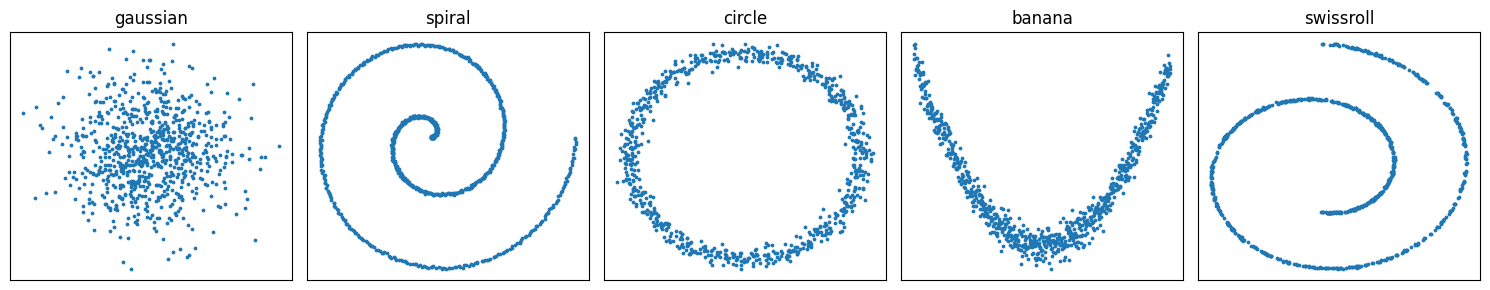

In [12]:
if __name__ == "__main__":
    kinds = ['gaussian', 'spiral', 'circle', 'banana', 'swissroll']
    plt.figure(figsize=(15, 3))
    for i, k in enumerate(kinds):
        X_temp = generate_point_cloud(kind=k, n=800, noise=0.05, random_state=0)
        plt.subplot(1, 5, i + 1)
        plt.scatter(X_temp[:, 0], X_temp[:, 1], s=3)
        plt.title(k)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()


In [13]:
def evaluate_translations(
    kind='gaussian',
    n_points=1000,
    noise=0.05,
    random_state=42,
    n_translations=10,
    max_shift=5.0
):
    """
    对给定类型的点云，生成多组随机平移，评估各方法距离。
    返回一个字典：{方法名: [长度 = n_translations 的距离列表]}。
    """
    np.random.seed(random_state)

    # 1. 先生成原始点云 X
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)

    # 2. 预先对 X 做 PCA + Diffusion Embedding
    Xc, axes_X, proj_X = center_and_pca(X)                     
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])  

    # 3. 准备一个字典存放各方法距离值
    methods = [
        'RISWIE-PCA',
        'RISWIE-Diffusion',
        'SlicedW',
        'GromovW',
        'StandardOT',
        'Procrustes',
        'Centroid'
    ]
    results = {m: [] for m in methods}

    # 4. 做 n_translations 次“随机平移”
    for i in range(n_translations):
        t = np.random.uniform(-max_shift, max_shift, size=2)  # 随机平移向量 t
        Y = X + t  # Y 是平移后的点云

        # --- 4.1 RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)                       # 对 Y 做 PCA
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)    # 成本矩阵
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)      # RISWIE 距离
        results['RISWIE-PCA'].append(riswie_pca)

        # --- 4.2 RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        results['RISWIE-Diffusion'].append(riswie_diff)

        # --- 4.3 Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        results['SlicedW'].append(sw)

        # --- 4.4 Gromov–Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        results['GromovW'].append(gw)

        # --- 4.5 Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        results['StandardOT'].append(ot_d)

        # --- 4.6 Procrustes ---
        proc = procrustes_distance(X, Y)
        results['Procrustes'].append(proc)

        # --- 4.7 Centroid ---
        cent = centroid_distance(X, Y)
        results['Centroid'].append(cent)

    return results


In [15]:
# 调用示例：对“Gaussian”点云做 10 次随机平移（[-5,5] 区间），并打印结果
results_gauss = evaluate_translations(
    kind='gaussian',
    n_points=1000,
    noise=0.05,
    random_state=42,
    n_translations=10,
    max_shift=5.0
)

for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")


RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [2.7926 2.1089 3.73   2.5697 2.816  3.0676 2.6572 2.4275 0.619  3.0197]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.1487 3.1004 5.0532 3.6516 3.9217 4.3477 3.7276 3.5663 0.9176 4.2027]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.1487 3.1004 5.0532 3.6516 3.9217 4.3477 3.7276 3.5663 0.9176 4.2027]


In [17]:
# 调用示例：对“Gaussian”点云做 10 次随机平移（[-5,5] 区间），并打印结果
results_gauss = evaluate_translations(
    kind='gaussian',
    n_points=1000,
    noise=0.2,
    random_state=42,
    n_translations=10,
    max_shift=5.0
)

for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")

RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [2.7926 2.1089 3.73   2.5697 2.816  3.0676 2.6572 2.4275 0.619  3.0197]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.1487 3.1004 5.0532 3.6516 3.9217 4.3477 3.7276 3.5663 0.9176 4.2027]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.1487 3.1004 5.0532 3.6516 3.9217 4.3477 3.7276 3.5663 0.9176 4.2027]
